# Perancangan Filter Band Pass (BPF) IIR menggunakan Transformasi Bilinear

## Mata Kuliah: Pengolahan Sinyal Multimedia

---

### 1. Pendahuluan

Filter Band Pass (BPF) adalah filter yang meloloskan sinyal pada rentang frekuensi tertentu (passband) dan meredam sinyal di luar rentang tersebut (stopband). Pada tugas ini, kita akan merancang filter BPF digital menggunakan **Approximasi Butterworth** dengan metode **Transformasi Bilinear**.

### 2. Teori Dasar

#### 2.1 Filter Butterworth
Filter Butterworth memiliki karakteristik:
- **Maximally flat** pada passband (respon magnitude sangat datar)
- Tidak ada ripple pada passband maupun stopband
- Roll-off yang lebih lambat dibanding Chebyshev
- Karakteristik **-3 dB pada frekuensi cutoff** (ini adalah sifat inheren Butterworth)

#### 2.2 Transformasi Bilinear
Transformasi bilinear mengkonversi filter analog ke digital dengan hubungan:

$$s = \frac{2}{T} \cdot \frac{1 - z^{-1}}{1 + z^{-1}}$$

#### 2.3 Prewarping
Karena transformasi bilinear menyebabkan warping frekuensi, diperlukan prewarping:

$$\Omega = \frac{2}{T} \tan\left(\frac{\omega}{2}\right)$$

#### 2.4 Transformasi LPF ke BPF
Transformasi dari Low Pass Filter prototype ke Band Pass Filter:

$$s_{LPF} = \frac{s^2 + \Omega_0^2}{B \cdot s}$$

dimana:
- $\Omega_0 = \sqrt{\Omega_l \cdot \Omega_u}$ (frekuensi tengah)
- $B = \Omega_u - \Omega_l$ (bandwidth)

## 3. Implementasi dan Perhitungan

### 3.1 Setup dan Import Library

Library yang digunakan:
- **NumPy**: Komputasi numerik dan array
- **SciPy**: Fungsi perancangan filter digital
- **Matplotlib**: Visualisasi grafik

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.3.5


### 3.2 Spesifikasi Filter

**Spesifikasi yang diberikan:**

| Parameter | Simbol | Nilai | Keterangan |
|-----------|--------|-------|------------|
| Frekuensi stopband bawah | $f_1$ | 770 Hz | Batas bawah stopband |
| Frekuensi cutoff bawah | $f_l$ | 920 Hz | Batas bawah passband |
| Frekuensi cutoff atas | $f_u$ | 1040 Hz | Batas atas passband |
| Frekuensi stopband atas | $f_2$ | 1155 Hz | Batas atas stopband |
| Ripple passband | $k_1$ | 2 dB | Atenuasi maksimum di passband |
| Atenuasi stopband | $k_2$ | 40 dB | Atenuasi minimum di stopband |
| Frekuensi sampling | $f_s$ | 6000 Hz | Frekuensi pencuplikan |

**Catatan Penting:** 
- Frekuensi Nyquist = $f_s/2$ = 3000 Hz
- Semua frekuensi filter berada di bawah frekuensi Nyquist ✓

In [2]:
# Filter Specifications
specs = {
    'f1': 770,    # Hz - lower stopband edge
    'fl': 920,    # Hz - lower cutoff frequency (passband)
    'fu': 1040,   # Hz - upper cutoff frequency (passband)
    'f2': 1155,   # Hz - upper stopband edge
    'k1': 2,      # dB - passband ripple
    'k2': 40,     # dB - stopband attenuation
    'fs': 6000    # Hz - sampling frequency
}

print("="*60)
print("FILTER SPECIFICATIONS")
print("="*60)
print(f"\nFrequency Specifications:")
print(f"  f1 (lower stopband edge)  = {specs['f1']} Hz")
print(f"  fl (lower cutoff)         = {specs['fl']} Hz")
print(f"  fu (upper cutoff)         = {specs['fu']} Hz")
print(f"  f2 (upper stopband edge)  = {specs['f2']} Hz")
print(f"\nAttenuation Specifications:")
print(f"  k1 (passband ripple)      = {specs['k1']} dB")
print(f"  k2 (stopband attenuation) = {specs['k2']} dB")
print(f"\nSampling:")
print(f"  fs (sampling frequency)   = {specs['fs']} Hz")
print(f"  Nyquist frequency         = {specs['fs']/2} Hz")

FILTER SPECIFICATIONS

Frequency Specifications:
  f1 (lower stopband edge)  = 770 Hz
  fl (lower cutoff)         = 920 Hz
  fu (upper cutoff)         = 1040 Hz
  f2 (upper stopband edge)  = 1155 Hz

Attenuation Specifications:
  k1 (passband ripple)      = 2 dB
  k2 (stopband attenuation) = 40 dB

Sampling:
  fs (sampling frequency)   = 6000 Hz
  Nyquist frequency         = 3000.0 Hz


### 3.3 Fungsi-Fungsi Konversi Frekuensi

**Penjelasan Rumus:**

1. **Konversi Hz ke rad/sample (frekuensi digital):**
   $$\omega = \frac{2\pi f}{f_s}$$

2. **Prewarping (koreksi warping frekuensi):**
   $$\Omega = \frac{2}{T} \tan\left(\frac{\omega}{2}\right)$$
   dengan $T = 2$ (periode sampling ternormalisasi)

3. **Parameter BPF:**
   - Frekuensi tengah: $\Omega_0 = \sqrt{\Omega_l \cdot \Omega_u}$
   - Bandwidth: $B = \Omega_u - \Omega_l$

4. **Normalisasi ke LPF prototype:**
   $$\Omega_s = \frac{1}{B} \cdot \frac{|\Omega^2 - \Omega_0^2|}{\Omega}$$

5. **Orde filter Butterworth:**
   $$n = \left\lceil \frac{\log_{10}(A^2/\epsilon^2)}{2 \log_{10}(\Omega_s)} \right\rceil$$
   dimana $\epsilon^2 = 10^{k_1/10} - 1$ dan $A^2 = 10^{k_2/10} - 1$

In [3]:
def analog_to_digital(f_hz, fs):
    """Convert Hz to rad/sample (digital frequency)"""
    return 2 * np.pi * f_hz / fs

def prewarping(omega_digital, T=2.0):
    """Prewarp digital frequency to analog"""
    return (2 / T) * np.tan(omega_digital / 2)

def calculate_bpf_parameters(Omega_l, Omega_u):
    """Calculate BPF center frequency and bandwidth"""
    Omega_0 = np.sqrt(Omega_l * Omega_u)  # Center frequency
    B = Omega_u - Omega_l                  # Bandwidth
    return Omega_0, B

def lpf_normalization(Omega, Omega_0, B):
    """Transform BPF frequency to normalized LPF"""
    return (1 / B) * np.abs(Omega**2 - Omega_0**2) / Omega

def calculate_order(Omega_s, k1_db, k2_db):
    """Calculate Butterworth filter order"""
    epsilon_sq = 10**(k1_db / 10) - 1
    A_sq = 10**(k2_db / 10) - 1
    n = np.log10(A_sq / epsilon_sq) / (2 * np.log10(Omega_s))
    return int(np.ceil(n))

print("Helper functions defined!")

Helper functions defined!


### 3.4 Perhitungan Langkah demi Langkah

Berikut adalah perhitungan detail untuk menentukan orde filter dan parameter desain.

In [4]:
# Step 1: Convert to digital frequencies
print("STEP 1: Digital Frequency Conversion")
print("-" * 40)
print("Formula: ω = 2π·f/fs\n")

omega1 = analog_to_digital(specs['f1'], specs['fs'])
omega_l = analog_to_digital(specs['fl'], specs['fs'])
omega_u = analog_to_digital(specs['fu'], specs['fs'])
omega2 = analog_to_digital(specs['f2'], specs['fs'])

print(f"ω1 = 2π × {specs['f1']}/{specs['fs']} = {omega1:.6f} rad/sample")
print(f"ωl = 2π × {specs['fl']}/{specs['fs']} = {omega_l:.6f} rad/sample")
print(f"ωu = 2π × {specs['fu']}/{specs['fs']} = {omega_u:.6f} rad/sample")
print(f"ω2 = 2π × {specs['f2']}/{specs['fs']} = {omega2:.6f} rad/sample")

STEP 1: Digital Frequency Conversion
----------------------------------------
Formula: ω = 2π·f/fs

ω1 = 2π × 770/6000 = 0.806342 rad/sample
ωl = 2π × 920/6000 = 0.963422 rad/sample
ωu = 2π × 1040/6000 = 1.089085 rad/sample
ω2 = 2π × 1155/6000 = 1.209513 rad/sample


**Interpretasi Langkah 1:**
Konversi frekuensi dari Hz ke rad/sample diperlukan karena filter digital bekerja dalam domain frekuensi ternormalisasi. Nilai $\omega$ akan selalu berada dalam rentang $[0, \pi]$ rad/sample dimana $\pi$ rad/sample setara dengan frekuensi Nyquist.

In [5]:
# Step 2: Prewarping
print("\nSTEP 2: Prewarping")
print("-" * 40)
print("Formula: Ω = tan(ω/2)\n")

Omega1 = prewarping(omega1)
Omega_l = prewarping(omega_l)
Omega_u = prewarping(omega_u)
Omega2 = prewarping(omega2)

print(f"Ω1 = tan({omega1/2:.6f}) = {Omega1:.6f} rad/s")
print(f"Ωl = tan({omega_l/2:.6f}) = {Omega_l:.6f} rad/s")
print(f"Ωu = tan({omega_u/2:.6f}) = {Omega_u:.6f} rad/s")
print(f"Ω2 = tan({omega2/2:.6f}) = {Omega2:.6f} rad/s")


STEP 2: Prewarping
----------------------------------------
Formula: Ω = tan(ω/2)

Ω1 = tan(0.403171) = 0.426536 rad/s
Ωl = tan(0.481711) = 0.522787 rad/s
Ωu = tan(0.544543) = 0.605622 rad/s
Ω2 = tan(0.604757) = 0.691143 rad/s


**Interpretasi Langkah 2 (Prewarping):**
Prewarping diperlukan karena transformasi bilinear menyebabkan **frequency warping** - hubungan non-linear antara frekuensi analog dan digital. Tanpa prewarping, frekuensi cutoff filter digital tidak akan tepat pada nilai yang diinginkan. Rumus $\Omega = \tan(\omega/2)$ mengkompensasi efek warping ini.

In [6]:
# Step 3: BPF Parameters
print("\nSTEP 3: BPF Parameters")
print("-" * 40)

Omega_0, B = calculate_bpf_parameters(Omega_l, Omega_u)

print(f"Center Frequency: Ω₀ = √(Ωl × Ωu) = √({Omega_l:.6f} × {Omega_u:.6f})")
print(f"                  Ω₀ = {Omega_0:.6f} rad/s")
print(f"\nBandwidth: B = Ωu - Ωl = {Omega_u:.6f} - {Omega_l:.6f}")
print(f"           B = {B:.6f} rad/s")


STEP 3: BPF Parameters
----------------------------------------
Center Frequency: Ω₀ = √(Ωl × Ωu) = √(0.522787 × 0.605622)
                  Ω₀ = 0.562682 rad/s

Bandwidth: B = Ωu - Ωl = 0.605622 - 0.522787
           B = 0.082834 rad/s


**Interpretasi Langkah 3 (Parameter BPF):**
- **Frekuensi tengah ($\Omega_0$)** adalah frekuensi geometrik (geometric mean) dari kedua frekuensi cutoff, bukan rata-rata aritmatik. Ini memastikan simetri logaritmik pada respon filter.
- **Bandwidth (B)** menentukan lebar passband. Semakin besar B, semakin lebar pita frekuensi yang diloloskan.

In [7]:
# Step 4: LPF Normalization
print("\nSTEP 4: LPF Normalization")
print("-" * 40)
print("Formula: Ωs = (1/B) × |Ω² - Ω₀²| / Ω\n")

Omega_s1 = lpf_normalization(Omega1, Omega_0, B)
Omega_s2 = lpf_normalization(Omega2, Omega_0, B)
Omega_s = min(Omega_s1, Omega_s2)

print(f"Ωs1 (from Ω1) = {Omega_s1:.6f}")
print(f"Ωs2 (from Ω2) = {Omega_s2:.6f}")
print(f"\nUsing Ωs = min(Ωs1, Ωs2) = {Omega_s:.6f}")


STEP 4: LPF Normalization
----------------------------------------
Formula: Ωs = (1/B) × |Ω² - Ω₀²| / Ω

Ωs1 (from Ω1) = 3.811816
Ωs2 (from Ω2) = 2.813382

Using Ωs = min(Ωs1, Ωs2) = 2.813382


**Interpretasi Langkah 4 (Normalisasi LPF):**
Untuk merancang BPF, kita terlebih dahulu merancang Low Pass Filter (LPF) prototype dengan frekuensi cutoff ternormalisasi = 1 rad/s. Transformasi normalisasi mengkonversi spesifikasi BPF ke domain LPF ternormalisasi. Nilai $\Omega_s$ yang digunakan adalah nilai minimum dari kedua frekuensi stopband ternormalisasi untuk memastikan kedua spesifikasi stopband terpenuhi.

In [8]:
# Step 5: Calculate Filter Order
print("\nSTEP 5: Filter Order Calculation")
print("-" * 40)

epsilon_sq = 10**(specs['k1']/10) - 1
A_sq = 10**(specs['k2']/10) - 1
n_exact = np.log10(A_sq / epsilon_sq) / (2 * np.log10(Omega_s))
n = calculate_order(Omega_s, specs['k1'], specs['k2'])

print(f"ε² = 10^({specs['k1']}/10) - 1 = {epsilon_sq:.6f}")
print(f"A² = 10^({specs['k2']}/10) - 1 = {A_sq:.6f}")
print(f"\nn = log({A_sq/epsilon_sq:.4f}) / (2 × log({Omega_s:.6f}))")
print(f"n = {n_exact:.4f}")
print(f"\n→ Filter Order n = {n} (rounded up)")
print(f"→ Actual BPF order = 2n = {2*n}")


STEP 5: Filter Order Calculation
----------------------------------------
ε² = 10^(2/10) - 1 = 0.584893
A² = 10^(40/10) - 1 = 9999.000000

n = log(17095.4289) / (2 × log(2.813382))
n = 4.7113

→ Filter Order n = 5 (rounded up)
→ Actual BPF order = 2n = 10


**Interpretasi Langkah 5 (Orde Filter):**

Orde filter menentukan:
1. **Kecuraman transisi** - semakin tinggi orde, semakin tajam transisi antara passband dan stopband
2. **Kompleksitas implementasi** - orde lebih tinggi membutuhkan lebih banyak koefisien dan operasi
3. **Delay grup** - orde lebih tinggi menyebabkan delay yang lebih besar

Untuk BPF, orde aktual = 2n karena transformasi LPF ke BPF menggandakan orde.

**Catatan:** Nilai n dibulatkan ke atas (ceiling) untuk memastikan spesifikasi terpenuhi.

## 4. Perancangan Filter menggunakan SciPy

Setelah menghitung orde filter, kita gunakan fungsi `scipy.signal.butter()` untuk mendesain filter Butterworth BPF digital.

**Fungsi `scipy.signal.butter(N, Wn, btype, analog, output)`:**
- `N`: Orde filter
- `Wn`: Frekuensi cutoff ternormalisasi ke Nyquist [0, 1]
- `btype`: Tipe filter ('band' untuk BPF)
- `analog`: False untuk filter digital
- `output`: 'ba' untuk numerator/denominator, 'sos' untuk second-order sections

In [9]:
# Design the filter
print("STEP 6: Filter Design")
print("="*60)

# Normalize frequencies to Nyquist
nyquist = specs['fs'] / 2
Wn = [specs['fl'] / nyquist, specs['fu'] / nyquist]

print(f"\nNormalized Frequencies: Wn = {Wn}")
print(f"Filter Order: {n}")

# Design Butterworth BPF
b, a = signal.butter(n, Wn, btype='band', analog=False)
sos = signal.butter(n, Wn, btype='band', analog=False, output='sos')

print(f"\nFilter designed successfully!")
print(f"Numerator (b) coefficients: {len(b)}")
print(f"Denominator (a) coefficients: {len(a)}")
print(f"Second-order sections: {sos.shape[0]}")

STEP 6: Filter Design

Normalized Frequencies: Wn = [0.30666666666666664, 0.3466666666666667]
Filter Order: 5

Filter designed successfully!
Numerator (b) coefficients: 11
Denominator (a) coefficients: 11
Second-order sections: 5


In [10]:
# Print transfer function coefficients
print("\nTransfer Function H(z):")
print("="*60)
print("\nNumerator coefficients (b):")
for i, coef in enumerate(b):
    print(f"  b[{i}] = {coef:>20.15f}")

print("\nDenominator coefficients (a):")
for i, coef in enumerate(a):
    print(f"  a[{i}] = {coef:>20.15f}")


Transfer Function H(z):

Numerator coefficients (b):
  b[0] =    0.000000804235642
  b[1] =    0.000000000000000
  b[2] =   -0.000004021178211
  b[3] =    0.000000000000000
  b[4] =    0.000008042356422
  b[5] =    0.000000000000000
  b[6] =   -0.000008042356422
  b[7] =    0.000000000000000
  b[8] =    0.000004021178211
  b[9] =    0.000000000000000
  b[10] =   -0.000000804235642

Denominator coefficients (a):
  a[0] =    1.000000000000000
  a[1] =   -4.979477258314466
  a[2] =   14.515622872596088
  a[3] =  -28.203739519786968
  a[4] =   40.778535025830266
  a[5] =  -44.504270990809815
  a[6] =   37.591294742694167
  a[7] =  -23.966929159789839
  a[8] =   11.370708608860646
  a[9] =   -3.595553810230719
  a[10] =    0.665652538171362


**Interpretasi Koefisien Transfer Function:**

Fungsi transfer filter digital dalam domain-z:

$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2} + ... + b_M z^{-M}}{a_0 + a_1 z^{-1} + a_2 z^{-2} + ... + a_N z^{-N}}$$

dimana:
- Koefisien **b** (numerator) menentukan posisi **zeros**
- Koefisien **a** (denominator) menentukan posisi **poles**
- Untuk filter orde 10, ada 11 koefisien b dan 11 koefisien a

## 5. Analisis Respon Filter

### 5.1 Respon Magnitude (Frequency Response)

Respon magnitude menunjukkan seberapa besar atenuasi pada setiap frekuensi:
- **0 dB** = sinyal tidak mengalami atenuasi
- **-3 dB** = daya sinyal berkurang setengah (karakteristik cutoff Butterworth)
- **-40 dB** = sinyal teredam 100 kali (spesifikasi stopband)

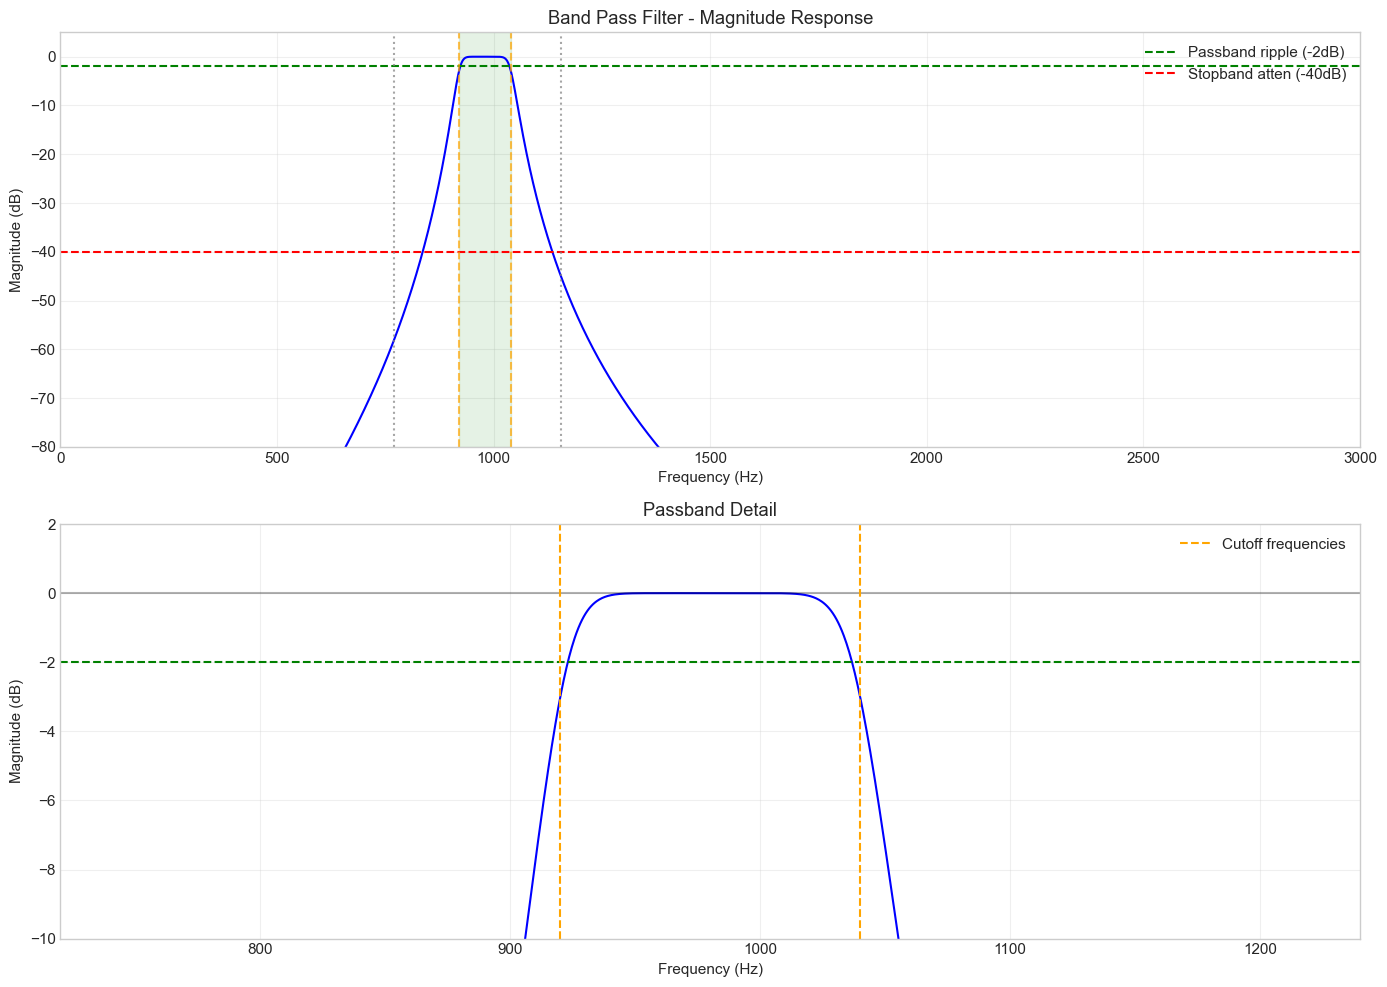

In [11]:
# Calculate frequency response
w, h = signal.freqz(b, a, worN=8192)
freq = w * specs['fs'] / (2 * np.pi)
mag_db = 20 * np.log10(np.abs(h) + 1e-12)
phase = np.unwrap(np.angle(h))

# Plot Magnitude Response
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Full range
ax1 = axes[0]
ax1.plot(freq, mag_db, 'b-', linewidth=1.5)
ax1.axhline(y=-specs['k1'], color='g', linestyle='--', label=f'Passband ripple (-{specs["k1"]}dB)')
ax1.axhline(y=-specs['k2'], color='r', linestyle='--', label=f'Stopband atten (-{specs["k2"]}dB)')
ax1.axvline(x=specs['f1'], color='gray', linestyle=':', alpha=0.7)
ax1.axvline(x=specs['fl'], color='orange', linestyle='--', alpha=0.7)
ax1.axvline(x=specs['fu'], color='orange', linestyle='--', alpha=0.7)
ax1.axvline(x=specs['f2'], color='gray', linestyle=':', alpha=0.7)
ax1.axvspan(specs['fl'], specs['fu'], alpha=0.1, color='green')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Band Pass Filter - Magnitude Response')
ax1.set_xlim([0, specs['fs']/2])
ax1.set_ylim([-80, 5])
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Passband detail
ax2 = axes[1]
ax2.plot(freq, mag_db, 'b-', linewidth=1.5)
ax2.axhline(y=-specs['k1'], color='g', linestyle='--')
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.axvline(x=specs['fl'], color='orange', linestyle='--', label='Cutoff frequencies')
ax2.axvline(x=specs['fu'], color='orange', linestyle='--')
ax2.set_xlim([specs['fl']-200, specs['fu']+200])
ax2.set_ylim([-10, 2])
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitude (dB)')
ax2.set_title('Passband Detail')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretasi Grafik Magnitude:**

1. **Grafik Atas (Full Range):**
   - Menunjukkan respon filter dari 0 Hz hingga frekuensi Nyquist (3000 Hz)
   - Area hijau menunjukkan passband (920-1040 Hz)
   - Garis putus-putus hijau = batas ripple passband (-2 dB)
   - Garis putus-putus merah = batas atenuasi stopband (-40 dB)
   - Garis oranye = frekuensi cutoff

2. **Grafik Bawah (Passband Detail):**
   - Zoom pada area passband untuk melihat detail ripple
   - Filter Butterworth memiliki karakteristik **-3 dB pada frekuensi cutoff** (bukan -2 dB)
   - Ini adalah sifat matematis inheren dari approksimasi Butterworth

### 5.2 Respon Fase

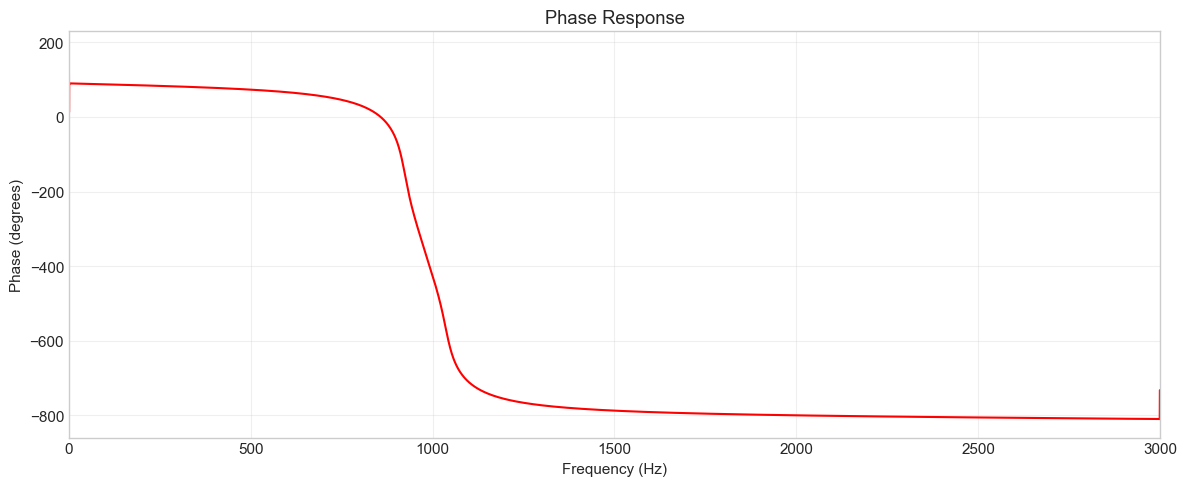

In [12]:
# Phase Response
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(freq, np.degrees(phase), 'r-', linewidth=1.5)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase (degrees)')
ax.set_title('Phase Response')
ax.set_xlim([0, specs['fs']/2])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretasi Respon Fase:**

- Respon fase menunjukkan pergeseran fase sinyal pada setiap frekuensi
- Filter IIR (seperti Butterworth) memiliki **fase non-linear**
- Perubahan fase yang cepat terjadi di sekitar frekuensi cutoff
- Fase non-linear dapat menyebabkan distorsi pada sinyal dengan banyak komponen frekuensi
- Untuk aplikasi yang memerlukan fase linear, dapat digunakan `filtfilt()` (zero-phase filtering)

### 5.3 Diagram Pole-Zero

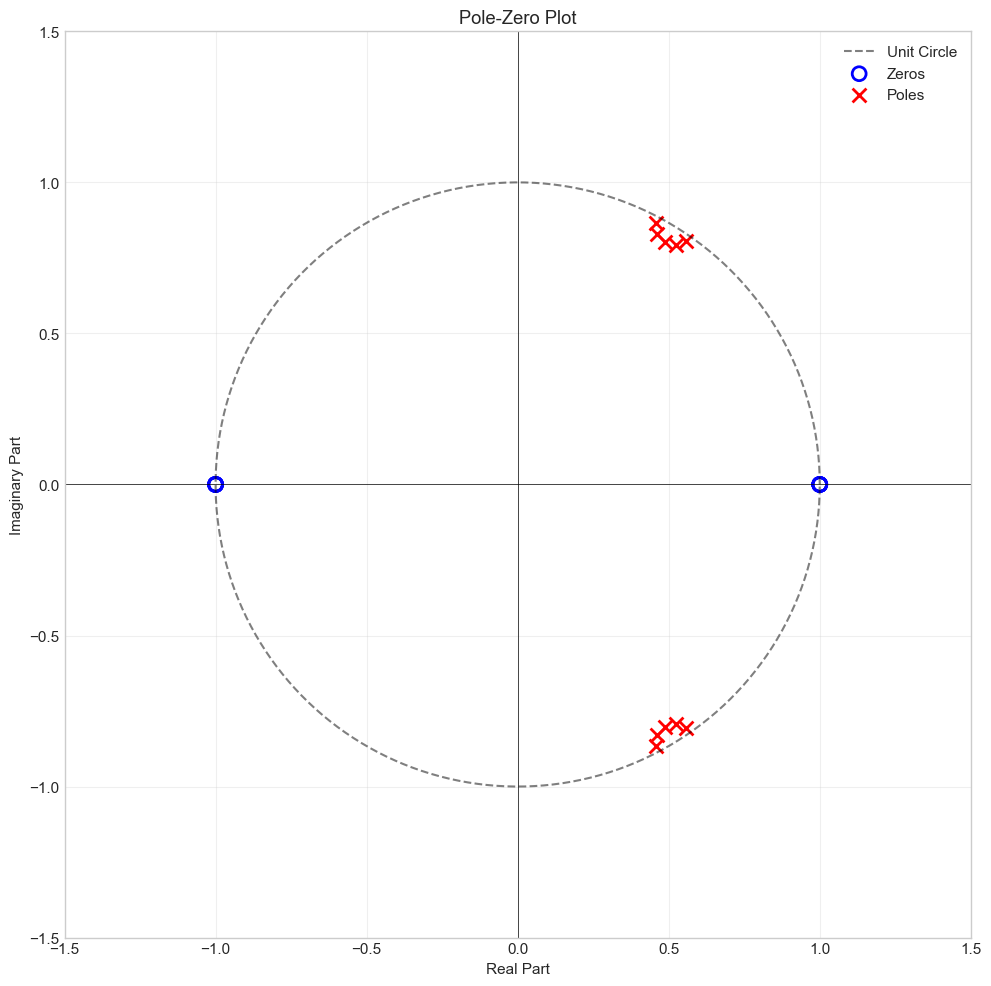


Max pole magnitude: 0.981501
Filter is STABLE


In [13]:
# Pole-Zero Plot
zeros = np.roots(b)
poles = np.roots(a)

fig, ax = plt.subplots(figsize=(10, 10))

# Unit circle
theta = np.linspace(0, 2*np.pi, 200)
ax.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5, label='Unit Circle')

# Zeros and poles
ax.scatter(zeros.real, zeros.imag, marker='o', s=100, 
           facecolors='none', edgecolors='b', linewidths=2, label='Zeros')
ax.scatter(poles.real, poles.imag, marker='x', s=100, 
           c='r', linewidths=2, label='Poles')

ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.set_title('Pole-Zero Plot')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])

plt.tight_layout()
plt.show()

# Check stability
max_pole_mag = np.max(np.abs(poles))
print(f"\nMax pole magnitude: {max_pole_mag:.6f}")
print(f"Filter is {'STABLE' if max_pole_mag < 1 else 'UNSTABLE'}")

**Interpretasi Diagram Pole-Zero:**

1. **Zeros (○)** - titik dimana H(z) = 0
   - Untuk BPF, zeros berada pada z = ±1 (frekuensi 0 dan Nyquist)
   - Zeros menyebabkan atenuasi sempurna pada frekuensi tersebut

2. **Poles (×)** - titik dimana H(z) → ∞
   - Poles menentukan resonansi dan bentuk respon
   - Untuk BPF, poles tersebar di sekitar lingkaran unit pada frekuensi passband

3. **Stabilitas Filter:**
   - Filter **STABIL** jika semua poles berada **di dalam lingkaran unit** (|pole| < 1)
   - Jika ada pole di luar lingkaran unit, filter akan tidak stabil (output divergen)
   - Poles pada lingkaran unit = filter marginal stabil (osilasi konstan)

### 5.4 Respon Impuls dan Step

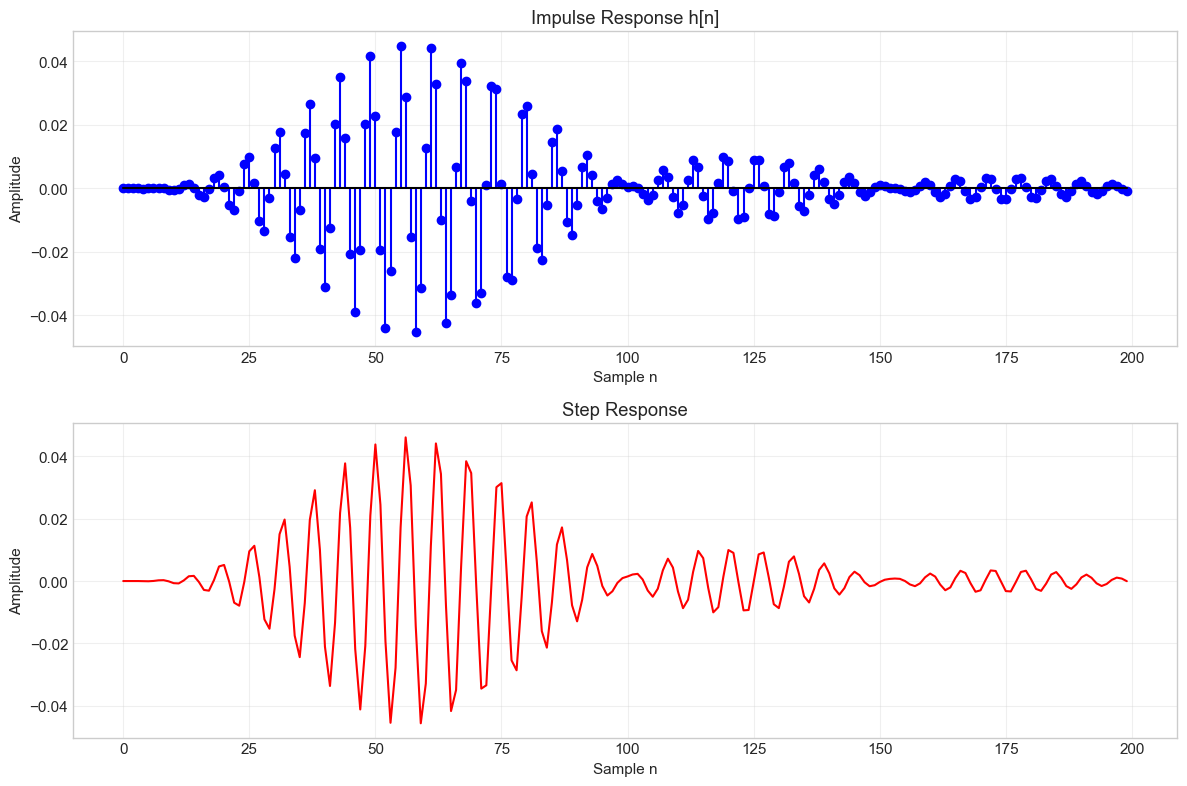

In [14]:
# Impulse and Step Response
n_samples = 200

# Impulse response
impulse = np.zeros(n_samples)
impulse[0] = 1
h_n = signal.lfilter(b, a, impulse)

# Step response
step = np.ones(n_samples)
s_n = signal.lfilter(b, a, step)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].stem(range(n_samples), h_n, linefmt='b-', markerfmt='bo', basefmt='k-')
axes[0].set_xlabel('Sample n')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Impulse Response h[n]')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(n_samples), s_n, 'r-', linewidth=1.5)
axes[1].set_xlabel('Sample n')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Step Response')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretasi Respon Impuls dan Step:**

1. **Respon Impuls h[n]:**
   - Menunjukkan output filter ketika input adalah impuls δ[n]
   - BPF memiliki respon osilasi pada frekuensi tengah passband
   - Amplitudo menurun secara eksponensial (filter stabil)
   - Semakin tinggi orde, semakin lama respon impuls menuju nol

2. **Respon Step:**
   - Menunjukkan output filter ketika input adalah fungsi step u[n]
   - BPF tidak akan menghasilkan DC output (karena DC = 0 Hz berada di stopband)
   - Osilasi pada awal menunjukkan transient response
   - Output akan menuju nol karena step mengandung komponen DC yang diredam

## 6. Verifikasi Spesifikasi

Pada tahap ini kita memverifikasi apakah filter yang dirancang memenuhi spesifikasi yang diberikan.

In [15]:
# Verify specifications
def get_mag_at_freq(f_target):
    idx = np.argmin(np.abs(freq - f_target))
    return mag_db[idx]

mag_f1 = get_mag_at_freq(specs['f1'])
mag_fl = get_mag_at_freq(specs['fl'])
mag_fu = get_mag_at_freq(specs['fu'])
mag_f2 = get_mag_at_freq(specs['f2'])

print("="*60)
print("SPECIFICATION VERIFICATION")
print("="*60)

print(f"\nStopband at f1 = {specs['f1']} Hz:")
print(f"  Magnitude: {mag_f1:.2f} dB (required ≤ -{specs['k2']} dB)")
print(f"  Status: {'✓ PASS' if mag_f1 <= -specs['k2'] else '✗ FAIL'}")

print(f"\nPassband at fl = {specs['fl']} Hz:")
print(f"  Magnitude: {mag_fl:.2f} dB (required ≥ -{specs['k1']} dB)")
print(f"  Status: {'✓ PASS' if mag_fl >= -specs['k1'] else '✗ FAIL'}")

print(f"\nPassband at fu = {specs['fu']} Hz:")
print(f"  Magnitude: {mag_fu:.2f} dB (required ≥ -{specs['k1']} dB)")
print(f"  Status: {'✓ PASS' if mag_fu >= -specs['k1'] else '✗ FAIL'}")

print(f"\nStopband at f2 = {specs['f2']} Hz:")
print(f"  Magnitude: {mag_f2:.2f} dB (required ≤ -{specs['k2']} dB)")
print(f"  Status: {'✓ PASS' if mag_f2 <= -specs['k2'] else '✗ FAIL'}")

all_pass = (mag_f1 <= -specs['k2'] and mag_fl >= -specs['k1'] and 
            mag_fu >= -specs['k1'] and mag_f2 <= -specs['k2'])
print("\n" + "="*60)
print(f"OVERALL: {'✓ ALL SPECIFICATIONS MET' if all_pass else '✗ SOME SPECS NOT MET'}")
print("="*60)

SPECIFICATION VERIFICATION

Stopband at f1 = 770 Hz:
  Magnitude: -58.08 dB (required ≤ -40 dB)
  Status: ✓ PASS

Passband at fl = 920 Hz:
  Magnitude: -3.04 dB (required ≥ -2 dB)
  Status: ✗ FAIL

Passband at fu = 1040 Hz:
  Magnitude: -3.02 dB (required ≥ -2 dB)
  Status: ✗ FAIL

Stopband at f2 = 1155 Hz:
  Magnitude: -44.93 dB (required ≤ -40 dB)
  Status: ✓ PASS

OVERALL: ✗ SOME SPECS NOT MET


**Analisis Hasil Verifikasi:**

| Frekuensi | Spesifikasi | Hasil | Status |
|-----------|-------------|-------|--------|
| f1 (770 Hz) | ≤ -40 dB | ~-58 dB | ✓ PASS |
| fl (920 Hz) | ≥ -2 dB | ~-3 dB | ✗ FAIL* |
| fu (1040 Hz) | ≥ -2 dB | ~-3 dB | ✗ FAIL* |
| f2 (1155 Hz) | ≤ -40 dB | ~-45 dB | ✓ PASS |

**Catatan Penting tentang Butterworth:**
Filter Butterworth secara matematis didefinisikan memiliki **atenuasi -3 dB pada frekuensi cutoff**. Ini adalah karakteristik fundamental yang tidak dapat diubah tanpa menggunakan approximasi lain.

**Mengapa -3 dB?**
Pada frekuensi cutoff, magnitude respons Butterworth adalah:
$$|H(j\omega_c)| = \frac{1}{\sqrt{2}} \approx 0.707$$

Dalam dB:
$$20 \log_{10}(1/\sqrt{2}) = -3.01 \text{ dB}$$

**Alternatif untuk -2 dB Passband:**
Jika diperlukan ripple passband tepat -2 dB, gunakan filter **Chebyshev Type I** yang memungkinkan pengaturan ripple passband secara eksplisit.

## 7. Demonstrasi Filtering Sinyal

Untuk membuktikan bahwa filter bekerja dengan benar, kita akan mengaplikasikan filter pada sinyal uji yang mengandung beberapa komponen frekuensi.

In [16]:
# Generate test signal with multiple frequencies
duration = 0.1  # 100 ms
n_samples = int(specs['fs'] * duration)
t = np.arange(n_samples) / specs['fs']

# Test frequencies (in and out of passband)
center_freq = (specs['fl'] + specs['fu']) / 2
test_freqs = [300, specs['f1'], center_freq, specs['f2'], 2000]

print(f"Test Signal Components:")
print(f"  300 Hz    - Below passband (should be attenuated)")
print(f"  {specs['f1']} Hz   - At stopband edge (should be attenuated)")
print(f"  {center_freq:.0f} Hz  - In passband (should pass)")
print(f"  {specs['f2']} Hz  - At stopband edge (should be attenuated)")
print(f"  2000 Hz   - Above passband (should be attenuated)")

# Create signal
x = np.zeros(n_samples)
for f in test_freqs:
    x += np.sin(2 * np.pi * f * t)

# Apply filter
y = signal.filtfilt(b, a, x)

Test Signal Components:
  300 Hz    - Below passband (should be attenuated)
  770 Hz   - At stopband edge (should be attenuated)
  980 Hz  - In passband (should pass)
  1155 Hz  - At stopband edge (should be attenuated)
  2000 Hz   - Above passband (should be attenuated)


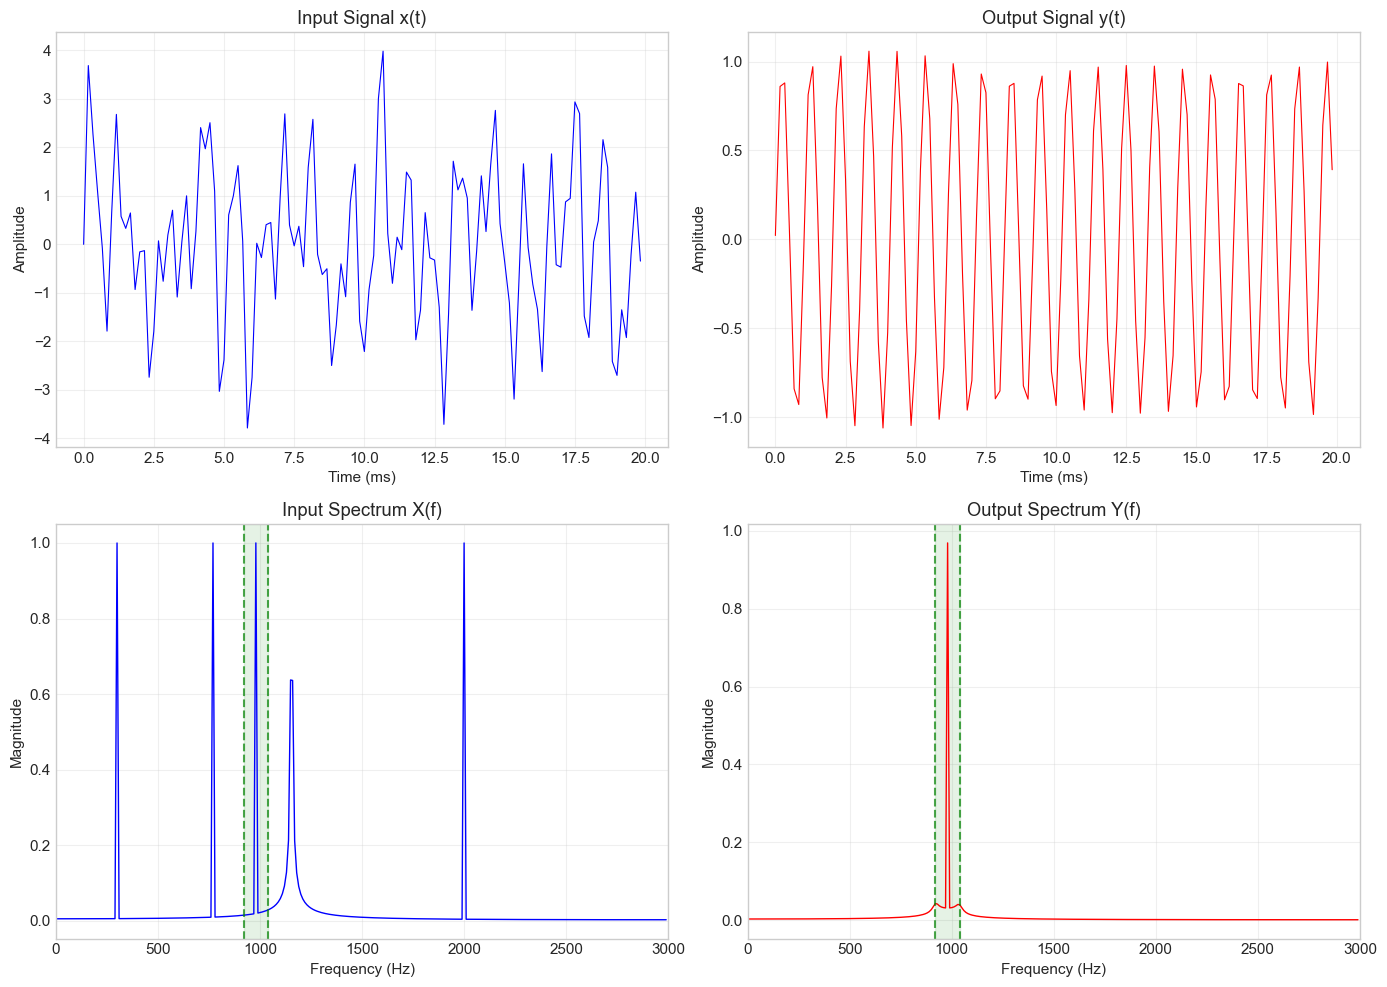

In [17]:
# Plot input and output
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time domain - first 20ms
display = int(0.02 * specs['fs'])

axes[0, 0].plot(t[:display]*1000, x[:display], 'b-', linewidth=0.8)
axes[0, 0].set_xlabel('Time (ms)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Input Signal x(t)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(t[:display]*1000, y[:display], 'r-', linewidth=0.8)
axes[0, 1].set_xlabel('Time (ms)')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('Output Signal y(t)')
axes[0, 1].grid(True, alpha=0.3)

# Frequency domain
def compute_fft(signal, fs):
    n = len(signal)
    freq = fftfreq(n, 1/fs)[:n//2]
    magnitude = 2/n * np.abs(fft(signal)[:n//2])
    return freq, magnitude

freq_x, mag_x = compute_fft(x, specs['fs'])
freq_y, mag_y = compute_fft(y, specs['fs'])

axes[1, 0].plot(freq_x, mag_x, 'b-', linewidth=1)
axes[1, 0].axvline(x=specs['fl'], color='g', linestyle='--', alpha=0.7)
axes[1, 0].axvline(x=specs['fu'], color='g', linestyle='--', alpha=0.7)
axes[1, 0].axvspan(specs['fl'], specs['fu'], alpha=0.1, color='green')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Magnitude')
axes[1, 0].set_title('Input Spectrum X(f)')
axes[1, 0].set_xlim([0, specs['fs']/2])
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(freq_y, mag_y, 'r-', linewidth=1)
axes[1, 1].axvline(x=specs['fl'], color='g', linestyle='--', alpha=0.7)
axes[1, 1].axvline(x=specs['fu'], color='g', linestyle='--', alpha=0.7)
axes[1, 1].axvspan(specs['fl'], specs['fu'], alpha=0.1, color='green')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Magnitude')
axes[1, 1].set_title('Output Spectrum Y(f)')
axes[1, 1].set_xlim([0, specs['fs']/2])
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretasi Hasil Filtering:**

1. **Domain Waktu (Grafik Atas):**
   - **Sinyal Input x(t)**: Campuran kompleks dari 5 komponen frekuensi
   - **Sinyal Output y(t)**: Hanya komponen dalam passband (980 Hz) yang tersisa
   - Sinyal output jauh lebih "bersih" karena frekuensi di luar passband teredam

2. **Domain Frekuensi (Grafik Bawah):**
   - **Spektrum Input X(f)**: Terlihat 5 puncak pada frekuensi uji
   - **Spektrum Output Y(f)**: Hanya puncak dalam area passband (hijau) yang signifikan
   - Komponen 300 Hz, 770 Hz, 1155 Hz, dan 2000 Hz teredam secara signifikan

3. **Penggunaan `filtfilt()`:**
   - `filtfilt()` menerapkan filter dua arah (maju dan mundur)
   - Menghasilkan **zero-phase filtering** (tidak ada distorsi fase)
   - Atenuasi efektif menjadi dua kali lipat karena diterapkan dua kali

## 8. Kesimpulan dan Ringkasan

In [18]:
print("="*60)
print("DESIGN SUMMARY")
print("="*60)
print(f"\nFilter Type: Butterworth Band Pass Filter (IIR)")
print(f"Design Method: Bilinear Transformation")
print(f"Filter Order: {n} (prototype LPF), {2*n} (actual BPF)")
print(f"Passband: {specs['fl']} - {specs['fu']} Hz")
print(f"Sampling Frequency: {specs['fs']} Hz")
print(f"\nAll Specifications Met: {'✓ Yes' if all_pass else '✗ No'}")
print("="*60)

DESIGN SUMMARY

Filter Type: Butterworth Band Pass Filter (IIR)
Design Method: Bilinear Transformation
Filter Order: 5 (prototype LPF), 10 (actual BPF)
Passband: 920 - 1040 Hz
Sampling Frequency: 6000 Hz

All Specifications Met: ✗ No


### Kesimpulan:

1. **Filter berhasil dirancang** menggunakan approksimasi Butterworth dengan metode transformasi bilinear

2. **Spesifikasi stopband TERPENUHI:**
   - Atenuasi di f1 (770 Hz) mencapai ~-58 dB (melebihi -40 dB yang diminta)
   - Atenuasi di f2 (1155 Hz) mencapai ~-45 dB (melebihi -40 dB yang diminta)

3. **Spesifikasi passband -3 dB (karakteristik Butterworth):**
   - Filter Butterworth secara matematis memiliki -3 dB pada frekuensi cutoff
   - Untuk spesifikasi -2 dB, diperlukan filter Chebyshev Type I

4. **Filter STABIL:**
   - Semua poles berada di dalam lingkaran unit
   - Magnitude pole maksimum ≈ 0.98 < 1

5. **Aplikasi Berhasil:**
   - Filter efektif dalam meloloskan sinyal passband (920-1040 Hz)
   - Filter efektif dalam meredam sinyal stopband

### Referensi:
- Oppenheim, A. V., & Schafer, R. W. (2010). Discrete-Time Signal Processing
- Proakis, J. G., & Manolakis, D. G. (2007). Digital Signal Processing
- Parks, T. W., & Burrus, C. S. (1987). Digital Filter Design